In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Proje_a_data/file1.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34000 entries, 0 to 33999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  34000 non-null  int64 
 1   text        33991 non-null  object
 2   class       34000 non-null  object
 3   tokens      34000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [ ]:
data.drop(columns = 'Unnamed: 0',inplace=True)

In [ ]:
import re

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub(r'@\w+','',text)
    #removes all text inside square brackets
    text = re.sub('\[.*?\]', '', text)
    #removes all URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #removes all non-word characters
    text = re.sub('[\W_]+', ' ', text)
    #removes all alphanumeric characters containing digits.
    text = re.sub('\w*\d\w*', '', text)
    #removes all non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    return text

In [ ]:
data['text'] = data["text"].apply(lambda x:clean_text(x))


KeyboardInterrupt: 

In [ ]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['text'] = data['text'].apply(remove_emojis)


In [ ]:
data['tokens'] = data['text'].apply(lambda x:nltk.word_tokenize(x))

In [ ]:
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())


data['tokens'] = [[word for word in txt if word not in stoplist] for txt in data['tokens']]



In [ ]:
ps = PorterStemmer()
data['tokens'] = data['tokens'].apply(lambda x : [ps.stem(i) for i in x])

In [ ]:
data['text']=data['tokens'].apply(lambda x : ' '.join(x))

In [ ]:
data.to_csv('/content/drive/MyDrive/Proje_a_data/file1.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33991 entries, 0 to 33999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33991 non-null  object
 1   class   33991 non-null  object
 2   tokens  33991 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [ ]:
x,y = data['text'],data['class']

In [ ]:
data.dropna(inplace=True)

In [ ]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

In [ ]:
X_train.shape,X_test.shape

((23793, 2788), (10198, 2788))

In [ ]:
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
y_train

31365    non-suicide
33799    non-suicide
12903        suicide
9029         suicide
25610    non-suicide
            ...     
33517    non-suicide
33809    non-suicide
5520         suicide
20465    non-suicide
18640    non-suicide
Name: class, Length: 23793, dtype: object

Naive Bayes

In [ ]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.9057983193277311
Testing score: 0.8890196078431373


In [ ]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

 non-suicide       0.90      0.88      0.89      5091
     suicide       0.88      0.90      0.89      5109

    accuracy                           0.89     10200
   macro avg       0.89      0.89      0.89     10200
weighted avg       0.89      0.89      0.89     10200



Random Forest

In [ ]:
classifiers = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],
                                                      'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
classifiers.fit(X_train, y_train)
print('Training score:',classifiers.score(X_train, y_train))
print('Testing score:',classifiers.score(X_test,y_test))
print(classifiers.best_estimator_)

Training score: 0.7855882352941177
Testing score: 0.7870588235294118
RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=3,
                       n_estimators=5)


              precision    recall  f1-score   support

 non-suicide       0.74      0.87      0.80      5091
     suicide       0.85      0.70      0.77      5109

    accuracy                           0.79     10200
   macro avg       0.80      0.79      0.79     10200
weighted avg       0.80      0.79      0.79     10200



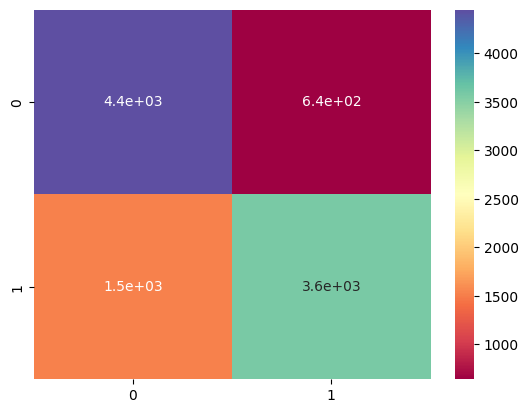

In [ ]:
y_act=y_test
y_pred=classifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='Spectral')
print(classification_report(y_act,y_pred))

Decision Tree

In [ ]:
model2 = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=70,max_depth=4,random_state=0)
model2.fit(X_train, y_train)
print(model2.score(X_train, y_train))
print(model2.score(X_test,y_test))

0.753109243697479
0.7568627450980392


              precision    recall  f1-score   support

 non-suicide       0.73      0.82      0.77      5091
     suicide       0.79      0.69      0.74      5109

    accuracy                           0.76     10200
   macro avg       0.76      0.76      0.76     10200
weighted avg       0.76      0.76      0.76     10200



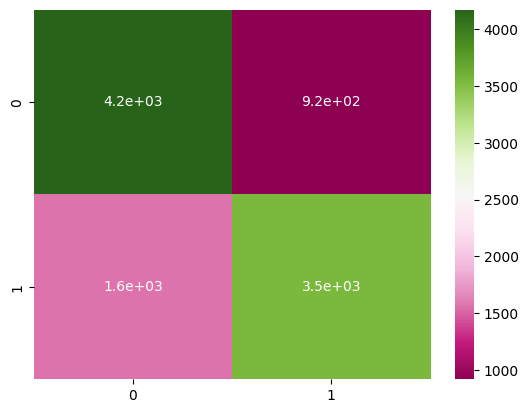

In [ ]:
y_act=y_test
y_pred=model2.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PiYG')
print(classification_report(y_act,y_pred))

Gradient Boosting

In [ ]:
model3 = RandomizedSearchCV(GradientBoostingClassifier(),{"learning_rate": range(3,5),
                "max_depth":[200],"max_features":range(6,10,2),
                 "n_estimators":[10]},random_state=8,n_jobs=-1)
model3.fit(X_train,y_train)
print('Training score:',model3.score(X_train,y_train))
print('Testing score:',model3.score(X_test,y_test))
model3.best_params_

Training score: 0.8228151260504202
Testing score: 0.7551960784313726


{'n_estimators': 10, 'max_features': 8, 'max_depth': 200, 'learning_rate': 4}

              precision    recall  f1-score   support

 non-suicide       0.72      0.83      0.77      5091
     suicide       0.80      0.68      0.74      5109

    accuracy                           0.76     10200
   macro avg       0.76      0.76      0.75     10200
weighted avg       0.76      0.76      0.75     10200



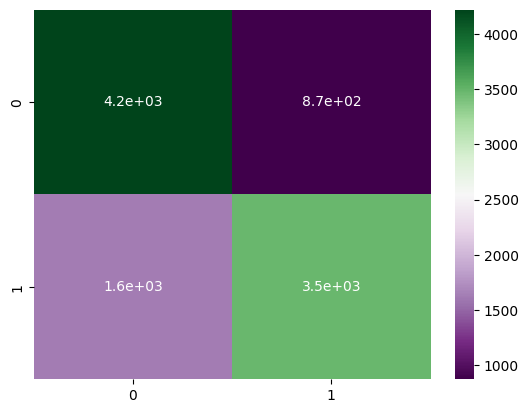

In [ ]:
#confusion matrix and classification report
y_act=y_test
y_pred=model3.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='PRGn')
print(classification_report(y_act,y_pred))

K-Nearest Neighbour

In [ ]:
model = RandomizedSearchCV(KNeighborsClassifier(),{'n_neighbors':[8],'metric':['manhattan','minkowski','cosine','tanimoto'],
                                                   'p':[1,2]},random_state=42,n_jobs=-1)
model.fit(X_train, y_train)
print('Training score:',model.score(X_train, y_train))
print('Testing score:',model.score(X_test,y_test))
print(model.best_estimator_)

In [ ]:
y_act = y_test
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [ ]:
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier with a linear kernel
classifier = svm.SVC(kernel='linear')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")


Decision Tree Classifier: Mean accuracy = 0.8377673974050553, Std deviation = 0.008312409530257255
Random Forest Classifier: Mean accuracy = 0.8874458962552016, Std deviation = 0.005524024439330493
Logistic Regression: Mean accuracy = 0.9224140799994575, Std deviation = 0.005721782313275666


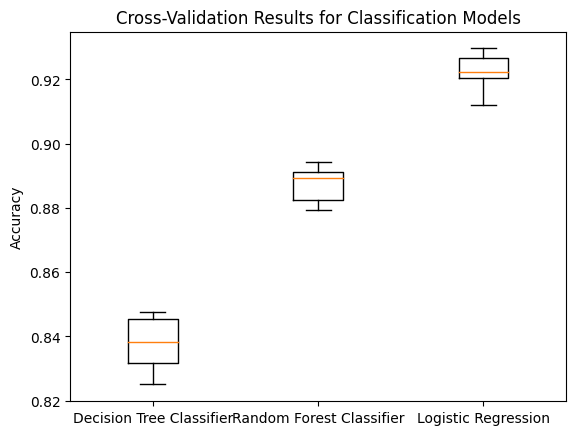

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt



# Define classification models
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression()
}

# Set up KFold for cross-validation
kf = KFold(n_splits=6, random_state=12, shuffle=True)

# Perform cross-validation for each model
results = []
for model_name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)
    print(f"{model_name}: Mean accuracy = {cv_results.mean()}, Std deviation = {cv_results.std()}")

# Visualize the results using boxplots
plt.boxplot(results, labels=models.keys())
plt.title('Cross-Validation Results for Classification Models')
plt.ylabel('Accuracy')
plt.show()
